In [114]:
import panel as pn
from panel.interact import interact
from panel import widgets
pn.extension('plotly')
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns 
import quandl
import numpy as np
import scipy.stats as stats
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import os
from pathlib import Path
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')  # ingore warnings

In [115]:
# ATM Dataset is merged with US state lebel population data. This is done in Postgres SQL. Importing into Pandas DataFrame for further processing
csvpath_atm_pop = Path("Resources/atm_pop.csv")
atm_pop_df = pd.read_csv(csvpath_atm_pop)
atm_pop_df.rename(columns={'state':'State','population':'Population','atm_count':'Bitcoin ATM'},inplace=True)

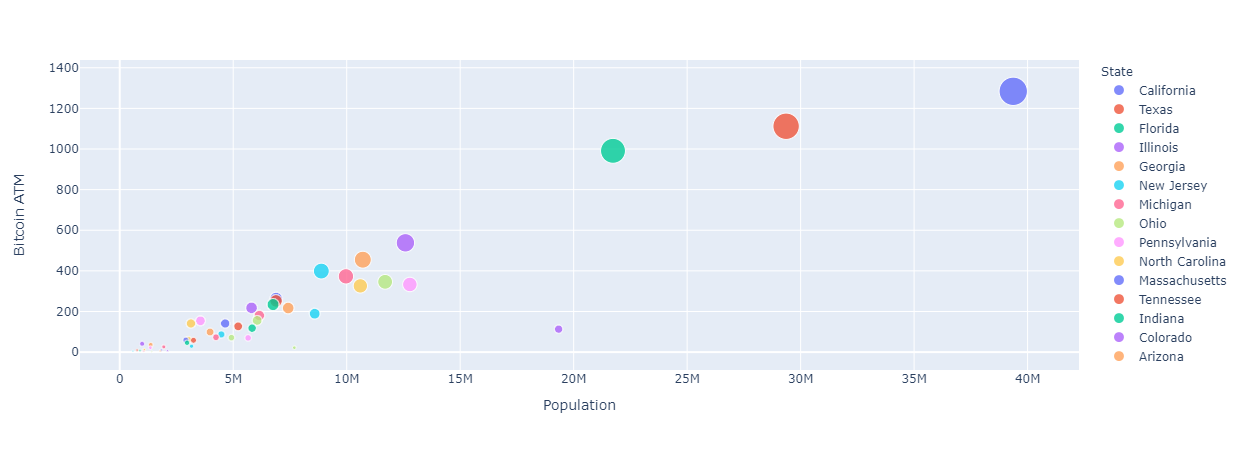

In [116]:
# Linear relationship with population and bitcoin ATMs, NY (4th largest largest state in terms of pop - is the exception
# NY needs special licensing for crypto business and operations in the state - bitlicensing
# That might have negatively infulenced number of ATMs
px.scatter(
    atm_pop_df,
    x="Population",
    y="Bitcoin ATM",
    size="Bitcoin ATM",
    color="State",
    opacity=0.8
)

In [117]:
# States with no bitcoin ATM

ATM_states = list(atm_pop_df['State'])
US_states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
            'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
            'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
            'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',
            'South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin',
            'Wyoming']
no_bitcoin_states = list(set(US_states) - set(ATM_states))
NY_atm = atm_pop_df.loc[atm_pop_df['State'] == 'New York']["Bitcoin ATM"].iloc[-1]

In [118]:
# Display few important stat
print(f"Total bitcoin ATMs in the USA     => {atm_pop_df['Bitcoin ATM'].sum()}")
print()
print(f"Average bitcoin ATMs per state    => {atm_pop_df['Bitcoin ATM'].mean():.0f}")
print(f"Bitcoin ATM in NY                 => {NY_atm}")
print()
print(f"Two states don't have Bitcoin ATM => {no_bitcoin_states}")

Total bitcoin ATMs in the USA     => 9527

Average bitcoin ATMs per state    => 198
Bitcoin ATM in NY                 => 113

Two states don't have Bitcoin ATM => ['Alaska', 'Vermont']


In [119]:
# Top 10 states in terms of number of Bitcoin ATMs per million population

atm_pop_df['per_million'] = (atm_pop_df['Bitcoin ATM']/atm_pop_df['Population'])*1000000
top10 = atm_pop_df.nlargest(10,'per_million')

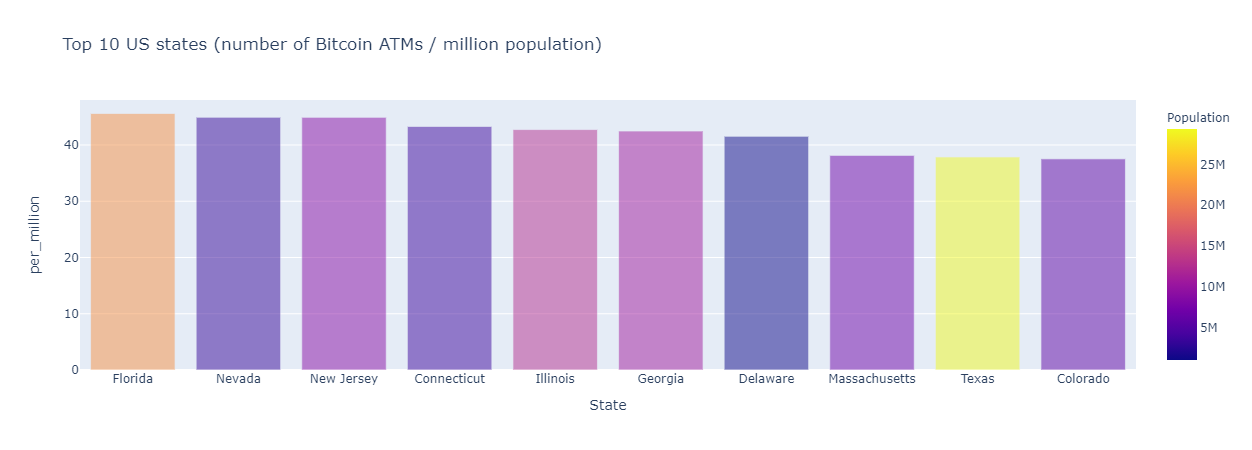

In [121]:
# Display top 10 states 

px.bar(
        top10,
        x="State",
        y="per_million",
        color = "Population",
        color_discrete_sequence=px.colors.qualitative.Antique,
        opacity = 0.5,
        title="Top 10 US states (number of Bitcoin ATMs / million population)"
    )

In [122]:
# After ATM data analysis in junction with population, let's visualize ATMs in US map using mapbox API. ATM data is already 
# pre-processed in postgres SQL

csvpath_city_atm = Path("Resources/city_atm.csv")
city_atm_df = pd.read_csv(csvpath_city_atm)
city_atm_df.head()

,city,lat,lon,atm
0,Houston,45.583290,-80.209415,222
1,Chicago,42.027845,-87.560258,150
2,Los Angeles,34.368041,-117.824839,141
3,Miami,26.647022,-80.126415,112
4,Las Vegas,36.297284,-115.053225,110


In [123]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

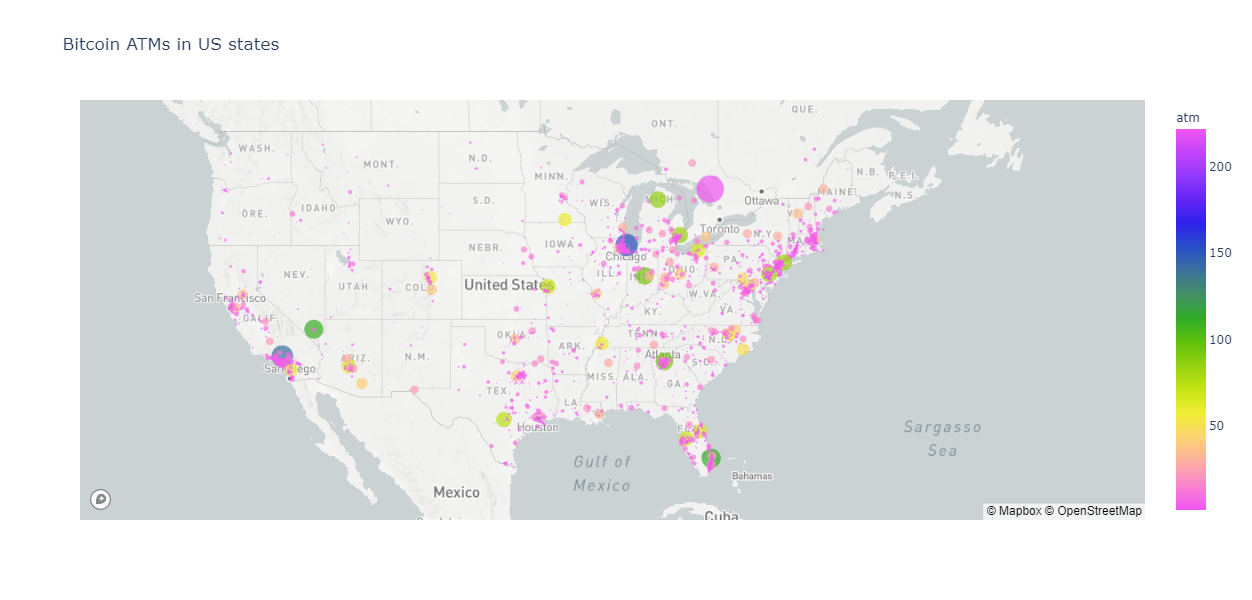

In [124]:
# Display ATM data in US map

px.scatter_mapbox(
        city_atm_df,
        lat="lat",
        lon="lon",
        size='atm',
        color='atm',
        color_continuous_scale=px.colors.cyclical.mygbm,
        hover_name='city',
        hover_data=['atm'],
        title="Bitcoin ATMs in US states",
        zoom=3,
        width=1000,
        height = 600
    )

In [125]:
# Source of crypto,csv is https://nomics.com/ -> Market Data -> Download CSV

csvpath_crypto = Path("Resources/crypto.csv")
crypto_df = pd.read_csv(csvpath_crypto)
crypto_df = crypto_df[['symbol','name','circulating_supply','market_cap','market_cap_dominance']]
total_mcap_trillion = (crypto_df['market_cap'].sum())/1000000000000
 

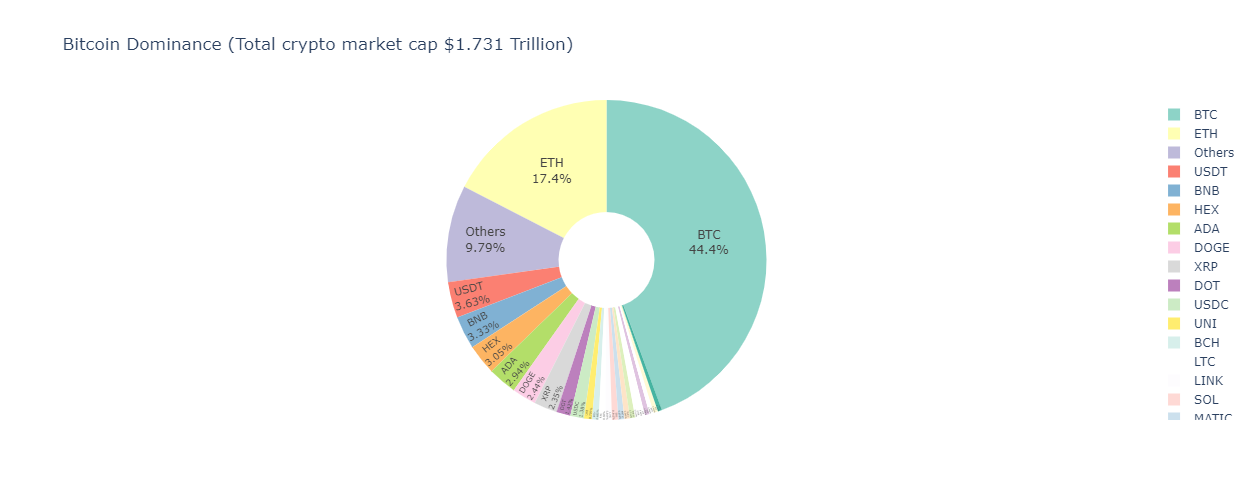

In [126]:
# Display BTC market share

df = px.data.tips()
fig = px.pie(
        crypto_df,
        values='market_cap',
        names='symbol',
        title=f'Bitcoin Dominance (Total crypto market cap ${total_mcap_trillion:.3f} Trillion)',
        color_discrete_sequence=px.colors.qualitative.Set3,
        hole = 0.3,
        width=600,
        height=500
    )
fig.update_traces(textposition='inside', textinfo='percent+label')

In [127]:
# Set timeframe for crypto data download from Yahoo Finance

start = pd.Timestamp("2014-09-16", tz="America/New_York").isoformat()
end = pd.Timestamp(pd.datetime.now(), tz="America/New_York").isoformat()

In [128]:
btc = web.DataReader("BTC-USD", 'yahoo', start, end) 
btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


In [129]:
# Data preparation for Candle chart

btc_candle = btc.loc['2021-01-01':'2021-06-14'][['Open','High','Low','Close']]
btc_candle.reset_index(inplace=True)
btc_candle['Date'] = pd.to_datetime(btc_candle['Date'])
btc_candle['Date'] = btc_candle['Date'].apply(mpl_dates.date2num)
btc_candle = btc_candle.astype(float)

AttributeError: 'Figure' object has no attribute 'autofmt_xdate'

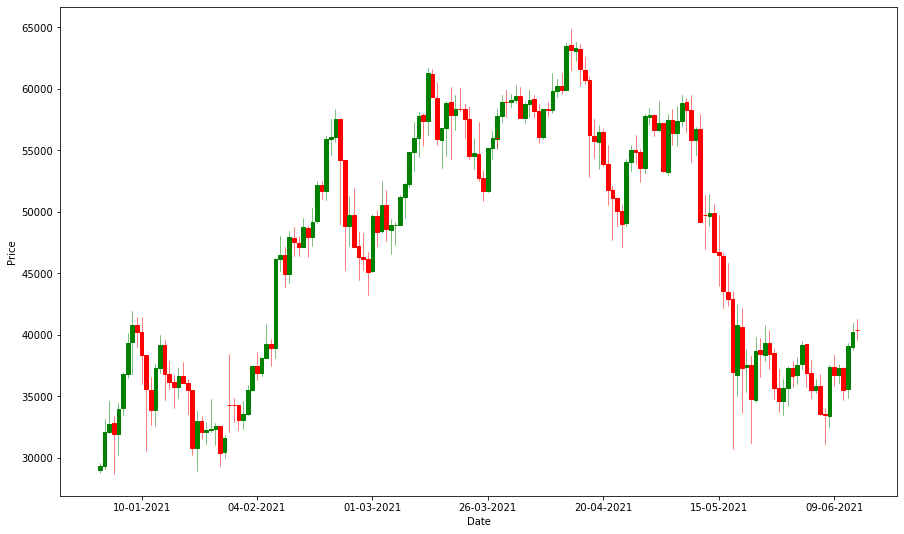

In [130]:
# Display Candle chart for 2021

figure, ax = plt.subplots(figsize = (15,9))
candlestick_ohlc(ax, btc_candle.values, width=0.8,colorup='green',colordown='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.sbptitle('Daily Candlestick Chart of Bitcoin')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [131]:
ohlc = btc.loc['2014-01-01':'2021-06-14'][['Open','High','Low','Close']]
ohlc.reset_index(inplace=True)
ohlc.head()

,Date,Open,High,Low,Close
0,2014-09-16,465.864014,468.174011,452.421997,457.334015
1,2014-09-17,456.859985,456.859985,413.104004,424.440002
2,2014-09-18,424.102997,427.834991,384.532013,394.795990
3,2014-09-19,394.673004,423.295990,389.882996,408.903992
4,2014-09-20,408.084991,412.425995,393.181000,398.821014


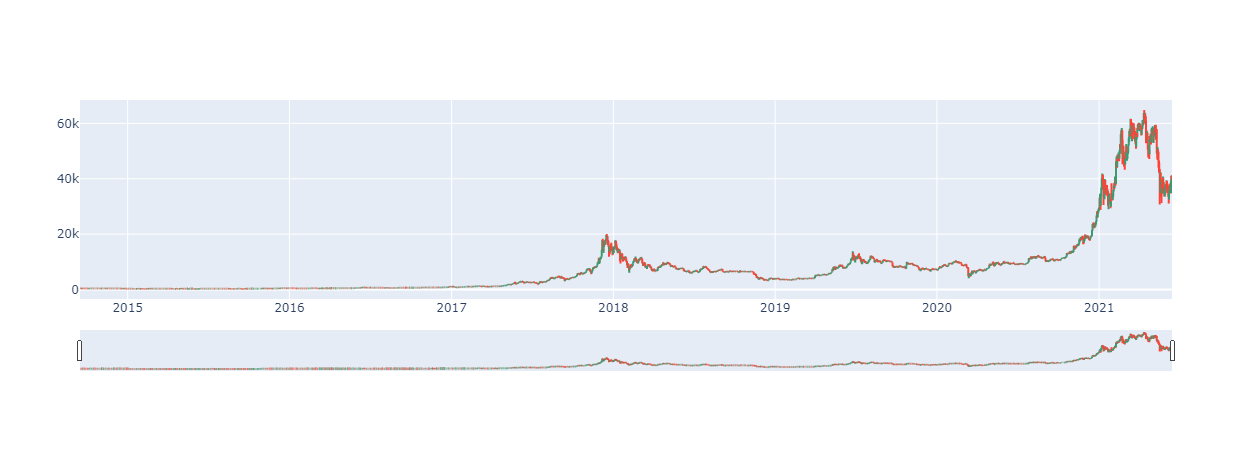

In [132]:
fig = go.Figure(data=go.Ohlc(x=ohlc['Date'],
                    open=ohlc['Open'],
                    high=ohlc['High'],
                    low=ohlc['Low'],
                    close=ohlc['Close']))
fig.show()

In [133]:
# Rename 'Adj Close' to 'BTC'
btc = btc[['Adj Close']]
btc = btc.rename(columns = {'Adj Close':'BTC'})

btc.index = btc.index.date
btc.isnull().sum()

BTC    0
dtype: int64

In [134]:
# Drop duplicate records

btc.drop_duplicates(inplace=True)

In [135]:
btc.shape

(2461, 1)

In [136]:
# Get SP500 daily close data from Yahoo Finance. '^GSPC' is the ticker for SP500.

sp500 = web.DataReader('^GSPC', 'yahoo', start, end) 

In [137]:
sp500.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [138]:
# Drop duplicate records

sp500.drop_duplicates(inplace=True)
sp500 = sp500[['Adj Close']]

sp500 = sp500.rename(columns = {'Adj Close':'SP500'})

In [139]:
sp500.head()

,SP500
Date,
2014-09-16,1998.979980
2014-09-17,2001.569946
2014-09-18,2011.359985
2014-09-19,2010.400024
2014-09-22,1994.290039


In [140]:
# Join Bitcoina and SP500 data

btc_sp500 = pd.concat([btc,sp500],axis=1,join="inner")
btc_sp500.head()

,BTC,SP500
2014-09-16,457.334015,1998.979980
2014-09-17,424.440002,2001.569946
2014-09-18,394.795990,2011.359985
2014-09-19,408.903992,2010.400024
2014-09-22,435.790985,1994.290039


In [141]:
# Calculate moving averages for Bitcoin

btc_ma = btc
btc_ma['7MA'] = btc_ma.BTC.rolling(7).mean()
btc_ma['20MA'] = btc_ma.BTC.rolling(20).mean()
btc_ma['50MA'] = btc_ma.BTC.rolling(50).mean()
btc_ma['200MA'] = btc_ma.BTC.rolling(200).mean()

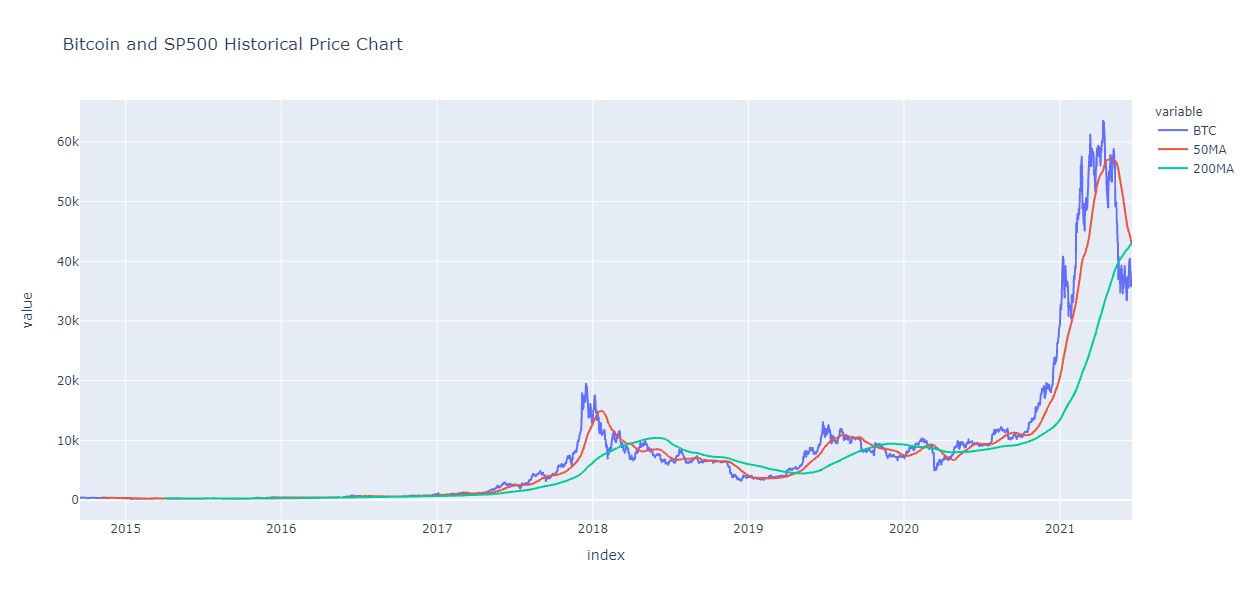

In [166]:
# Plot moving averages - MA50 is close to cross MA200.
px.line(
        btc,
        y=['BTC','50MA','200MA'],
        height = 600,
        width = 970,
        title = "Bitcoin and SP500 Historical Price Chart"
    )

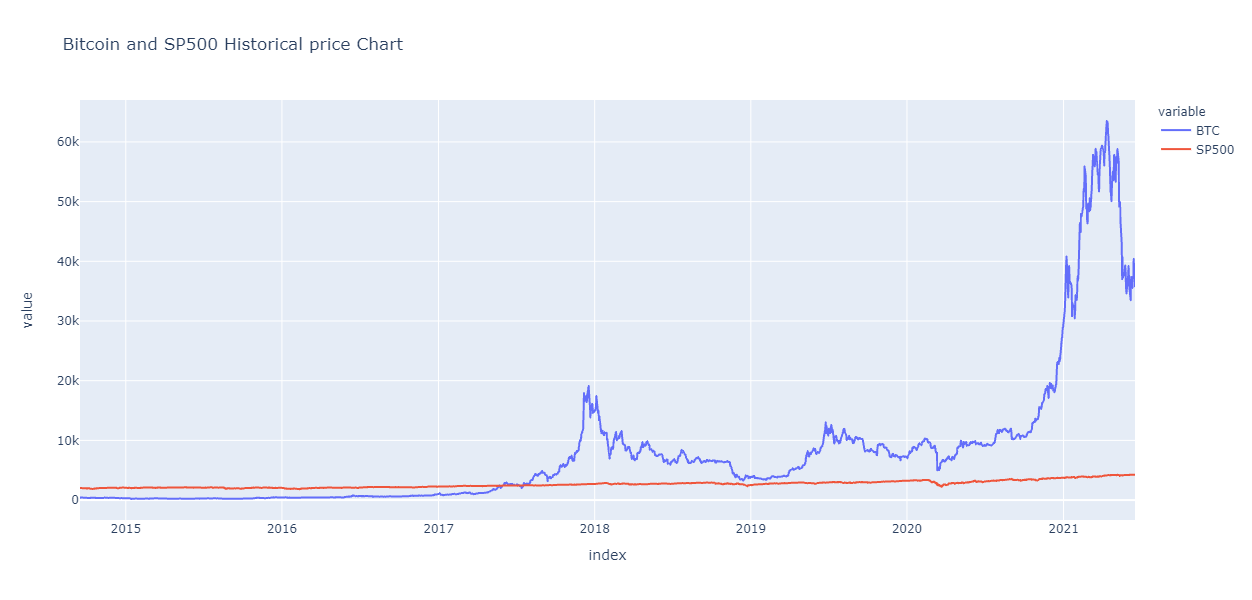

In [143]:
# SP500 
px.line(
        btc_sp500,
        height = 600,
        width = 1000,
        title = "Bitcoin and SP500 Historical price Chart"
    )

In [144]:
# Saved cleaned dataframes into local drive

btc.to_csv(r'C:\Users\tapas kumar roy\OneDrive\Desktop\class\project1\Resources\btc.csv', index = True)
sp500.to_csv(r'C:\Users\tapas kumar roy\OneDrive\Desktop\class\project1\Resources\sp500.csv', index = True)
btc_sp500.to_csv(r'C:\Users\tapas kumar roy\OneDrive\Desktop\class\project1\Resources\btc_sp500.csv', index = True)

In [145]:
btc_sp500.head()

,BTC,SP500
2014-09-16,457.334015,1998.979980
2014-09-17,424.440002,2001.569946
2014-09-18,394.795990,2011.359985
2014-09-19,408.903992,2010.400024
2014-09-22,435.790985,1994.290039


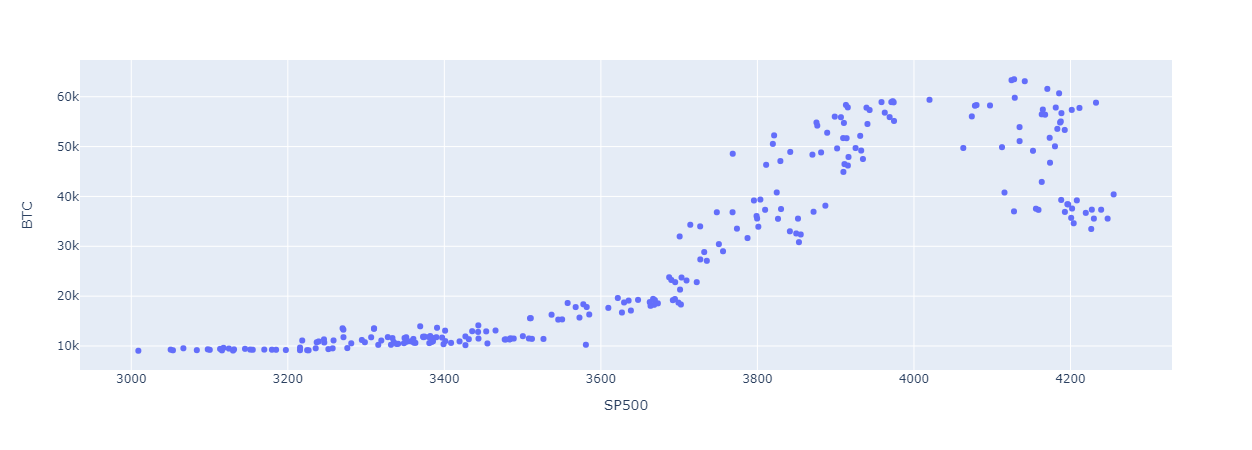

In [146]:
# Sctter plot between BTC and SP500

px.scatter(
    btc_sp500.loc['2020-06-14':'2021-06-14'],
    x="SP500",
    y="BTC"
)

In [147]:
# Display correlations

correlation_longterm = btc_sp500.loc['2014-09-14':'2020-12-01'].corr()
correlation_nearterm = btc_sp500.loc['2021-01-01':'2021-06-14'].corr()
print("***** LONGTERM CORRELATION *****")
print(correlation_longterm)
print()
print("***** SHORTTERM CORRELATION *****")
print(correlation_nearterm)
print()
print("CONCLUSION: BITCOIN IS GENERALLY STRONGLY CORRELATED WITH SP500 IN CRYPTO BEAR MARKET")

***** LONGTERM CORRELATION *****
            BTC     SP500
BTC    1.000000  0.884074
SP500  0.884074  1.000000

***** SHORTTERM CORRELATION *****
            BTC     SP500
BTC    1.000000  0.258544
SP500  0.258544  1.000000

CONCLUSION: BITCOIN IS GENERALLY STRONGLY CORRELATED WITH SP500 IN CRYPTO BEAR MARKET


In [148]:
# Rolling correlation

btc_sp500['BTC'].rolling(7).corr(btc_sp500['SP500'])

2014-09-16         NaN
2014-09-17         NaN
2014-09-18         NaN
2014-09-19         NaN
2014-09-22         NaN
                ...   
2021-06-11   -0.191998
2021-06-14    0.556695
2021-06-15    0.576988
2021-06-16    0.390709
2021-06-17    0.500757
Length: 1696, dtype: float64

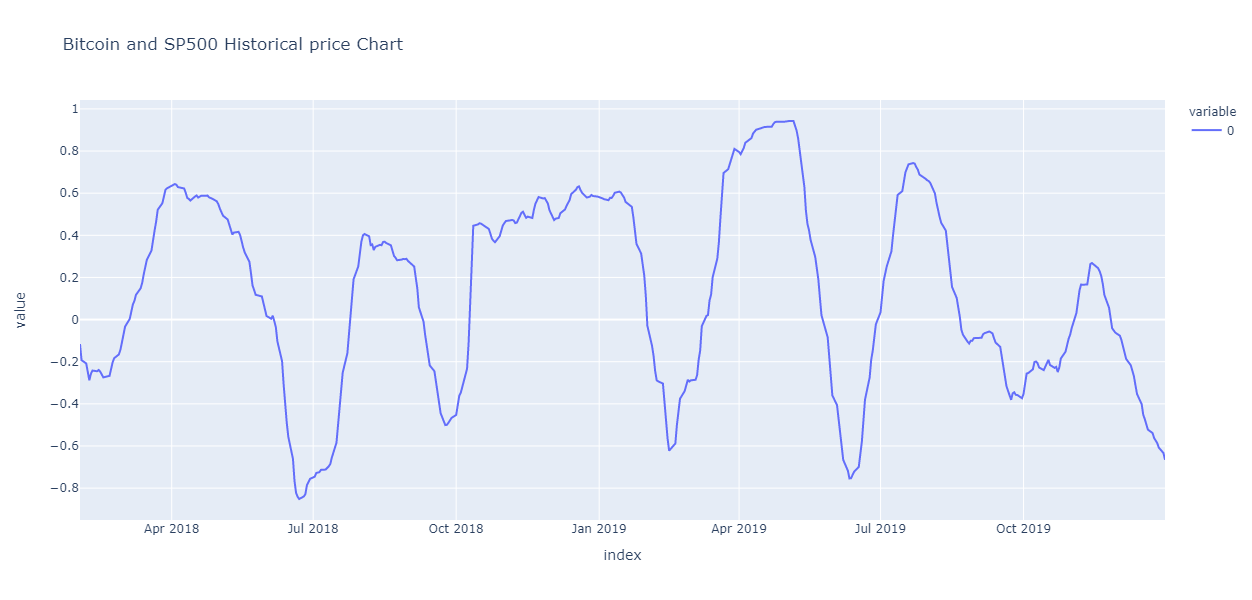

In [149]:
# Plot rolling correlation

px.line(
        btc_sp500['BTC'].rolling(50).corr(btc_sp500['SP500']).loc['2018-02-1':'2020-01-01'],
        height = 600,
        width = 1000,
        title = "Bitcoin and SP500 Historical price Chart"
    )
# Rolling correlation is pretty random - not concrete correlation. 

In [150]:
# Copy bitcoin price data to master_df which will be used to concatenate wallet data, hashrate data and difficulty data

master_df = btc
master_df.head()

,BTC,7MA,20MA,50MA,200MA
2014-09-16,457.334015,NaN,NaN,NaN,NaN
2014-09-17,424.440002,NaN,NaN,NaN,NaN
2014-09-18,394.795990,NaN,NaN,NaN,NaN
2014-09-19,408.903992,NaN,NaN,NaN,NaN
2014-09-20,398.821014,NaN,NaN,NaN,NaN


In [151]:
# Get Wallet data from Quandl

btcwallet = quandl.get("BCHAIN/MWNUS", authtoken="9wWEFV28U5nJKzzLsrxq")
btcwallet = btcwallet.rename(columns = {'Value':'Wallet'})
btcwallet = btcwallet.loc["2014-09-16":"2021-06-15"]
btcwallet.index = btcwallet.index.date

btcwallet.index.is_unique
btcwallet.drop_duplicates(inplace=True)

In [152]:
btcwallet.head()

,Wallet
2014-09-16,2207905.0
2014-09-17,2212540.0
2014-09-18,2218905.0
2014-09-19,2222984.0
2014-09-20,2227543.0


In [153]:
# Get difficulty data from Quandl

btcdifficulty = quandl.get("BCHAIN/DIFF", authtoken="9wWEFV28U5nJKzzLsrxq")
btcdifficulty = btcdifficulty.rename(columns = {'Value':'Difficulty'})
btcdifficulty = btcdifficulty.loc["2014-09-16":"2021-06-15"]
btcdifficulty.index = btcdifficulty.index.date

btcdifficulty.index.is_unique
btcdifficulty.drop_duplicates(inplace=True)

btcdifficulty.head()

,Difficulty
2014-09-16,2.982973e+10
2014-09-17,2.982973e+10
2014-09-26,3.466143e+10
2014-09-28,3.466143e+10
2014-10-08,3.500248e+10


In [154]:
# Get hashrate data from Quandl

btchashrate = quandl.get("BCHAIN/HRATE", authtoken="9wWEFV28U5nJKzzLsrxq")
btchashrate = btchashrate.rename(columns = {'Value':'Hash Rate'})
btchashrate = btchashrate.loc["2014-09-16":"2021-06-15"]
btchashrate.index = btchashrate.index.date

btchashrate.index.is_unique
btchashrate.drop_duplicates(inplace=True)

btchashrate.head()

,Hash Rate
2014-09-16,250600.648941
2014-09-17,274326.154167
2014-09-18,240220.740405
2014-09-19,240220.740405
2014-09-20,259497.713401


In [161]:
# Concatenate data for bitcoin, wallet, hashrate and difficulty data

btc_concatenated = pd.concat([master_df,btcwallet,btcdifficulty,btchashrate],axis=1,join="inner")
btc_concatenated = btc_concatenated[['BTC','Wallet','Difficulty','Hash Rate']]
# standardize the data with z-scoe
btc_concat_zcores = btc_concatenated.apply(stats.zscore)

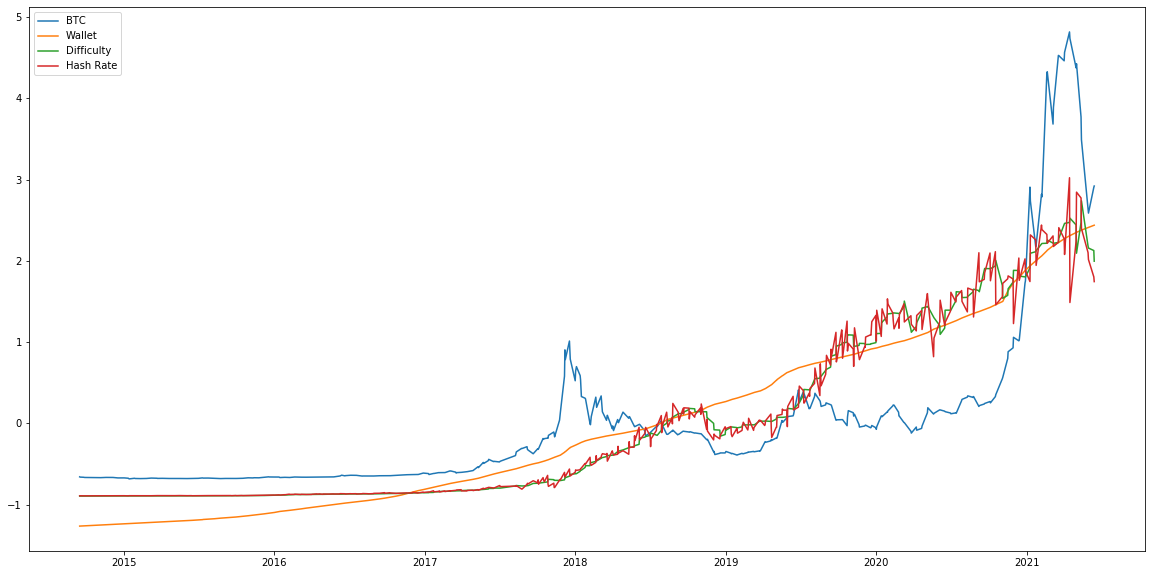

In [162]:
# Plot th concatenated data

btc_concat_zcores.plot(figsize=(20,10))

In [163]:
# Calculate correlation

btc_correlation = btc_concat_zcores.corr()
btc_correlation

,BTC,Wallet,Difficulty,Hash Rate
BTC,1.000000,0.764862,0.744317,0.739481
Wallet,0.764862,1.000000,0.968035,0.961593
Difficulty,0.744317,0.968035,1.000000,0.991597
Hash Rate,0.739481,0.961593,0.991597,1.000000


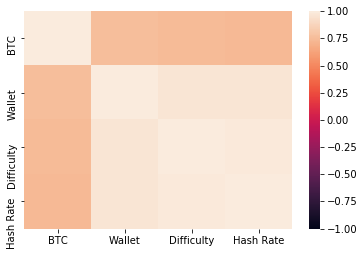

In [164]:
# Display correcations in a heatmap

sns.heatmap(btc_correlation, vmin=-1, vmax=1)